# Предсказание временных рядов с помощью машинного обучения

Поработайте с данными sunspot_numbers.xlsx - это данные о ежемесячном количестве наблюдаемых пятен на солнце.

Разбейте данные на train и test (test - последние 15% данных)

1) Сделайте предсказание с помощью fbprophet и измерьте mse и mae предсказания на train и на test

2) Поработайте над созданием новых признаков (лаги, аггрегированные признаки и т.д.) и примените для предсказания линейную регрессию и какой-нибудь нелинейный алгоритм.

3) Сравните результаты алгоритмов из п.1) и п.2)

4) Сделайте предсказание с помощью модели Хольта-Уинтерса и/или попробуйте применить модели ARIMA/SARIMA для предсказания.

Какая модель получилась наилучшей?

5) Попробуйте скомбинировать наилучшие модели.

In [20]:
import pandas as pd

df = pd.read_excel("sunspot_numbers.xlsx")
df.head()

,Month,SunspotNumbers
0,1749-01,58.0
1,1749-02,62.6
2,1749-03,70.0
3,1749-04,55.7
4,1749-05,85.0


In [28]:
int(df['Month'][0].split('-')[0])

1749

In [29]:
#your code here
df['Month'] = df['Month'].astype(str)

df['Year'] = df['Month'].apply(lambda x: int(x.split('-')[0]))
df['Month'] = df['Month'].apply(lambda x: int(x.split('-')[1]))

In [30]:
df.tail()

,Month,SunspotNumbers,Year
2815,8,71.8,1983
2816,9,50.3,1983
2817,10,55.8,1983
2818,11,33.3,1983
2819,12,33.4,1983


In [68]:
from sklearn.model_selection import train_test_split

def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    print(test_index,len(data))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.SunspotNumbers.shift(i)

    data['year_average'] = list(map(code_mean(data[:test_index], 'Year', "SunspotNumbers").get, data.Year))
    data["month_average"] = list(map(code_mean(data[:test_index], 'Month', "SunspotNumbers").get, data.Month))
    # выкидываем закодированные средними признаки 
    data.drop(["Month"], axis=1, inplace=True)

    data = data.dropna()

    X = data.drop(["SunspotNumbers"], axis=1)
    y = data["SunspotNumbers"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                       test_size=test_size, shuffle=False)
    
#     # разбиваем весь датасет на тренировочную и тестовую выборку
#     X_train = data.loc[:test_index].drop(["SunspotNumbers"], axis=1)
#     y_train = data.loc[:test_index]["SunspotNumbers"]
#     X_test = data.loc[test_index:].drop(["SunspotNumbers"], axis=1)
#     y_test = data.loc[test_index:]["SunspotNumbers"]

    return X_train, X_test, y_train, y_test

In [103]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(df2, test_size=0.3, lag_start=1, lag_end=132)
X_train.head()

1966 2810


,Year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,year_average,month_average
141,1760,64.00,62.50,60.91,62.03,64.33,62.23,61.40,58.83,57.58,...,91.19,87.82,88.30,87.82,87.40,85.38,85.05,82.79,61.876667,44.966319
142,1760,63.36,64.00,62.50,60.91,62.03,64.33,62.23,61.40,58.83,...,92.14,91.19,87.82,88.30,87.82,87.40,85.38,85.05,61.876667,45.356037
143,1760,62.60,63.36,64.00,62.50,60.91,62.03,64.33,62.23,61.40,...,94.89,92.14,91.19,87.82,88.30,87.82,87.40,85.38,61.876667,45.307683
144,1761,62.75,62.60,63.36,64.00,62.50,60.91,62.03,64.33,62.23,...,88.15,94.89,92.14,91.19,87.82,88.30,87.82,87.40,77.226667,45.168476
145,1761,62.28,62.75,62.60,63.36,64.00,62.50,60.91,62.03,64.33,...,86.20,88.15,94.89,92.14,91.19,87.82,88.30,87.82,77.226667,45.215000


In [104]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1287, 134), (1287,), (552, 134), (552,))

Populating the interactive namespace from numpy and matplotlib


C:\Users\elena\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


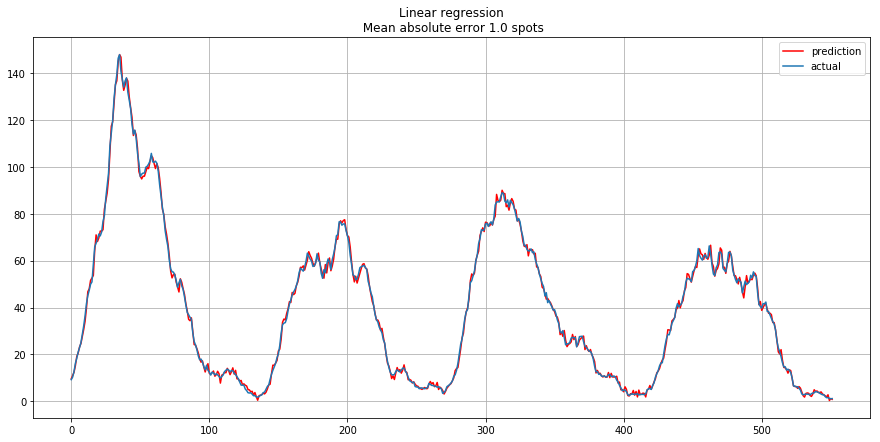

In [105]:
from matplotlib import pylab as plt
%pylab inline
from sklearn.metrics import mean_absolute_error

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} spots".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [106]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    #rolling_std =  series.rolling(window=n).std()
    #upper_bond = rolling_mean+1.96*rolling_std
    #lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.plot(df.SunspotNumbers[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "r", label="Rolling mean trend")

    #plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    #plt.plot(lower_bond, "r--")
    return rolling_mean

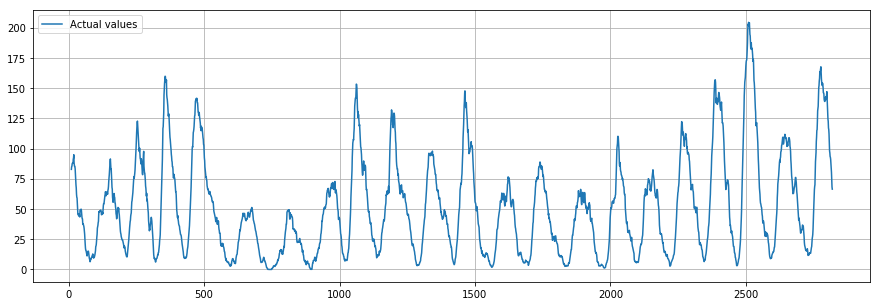

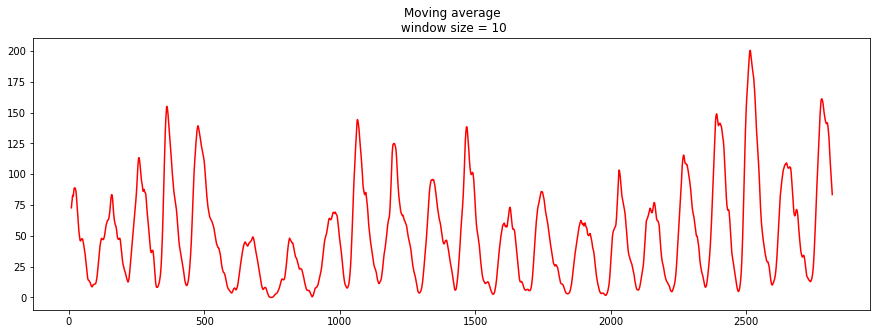

In [107]:
rolling_mean = plotMovingAverage(df['SunspotNumbers'],10)

In [99]:
rolling_mean = df['SunspotNumbers'].rolling(window=10).mean()

In [101]:
df2 = df.iloc[10:]
df2['SunspotNumbers'] = rolling_mean

C:\Users\elena\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [102]:
df2

,Month,SunspotNumbers,Year
10,11,82.79,1749
11,12,85.05,1749
12,1,85.38,1750
13,2,87.40,1750
14,3,87.82,1750
15,4,88.30,1750
16,5,87.82,1750
17,6,91.19,1750
18,7,92.14,1750
19,8,94.89,1750
